In [16]:
import os, getpass
def _set_env(var: str):
    if not os.environ.get(var):
        os.environ[var] = getpass.getpass(f"{var}: ")
# 
_set_env("ANTHROPIC_API_KEY")
_set_env("LANGCHAIN_API_KEY")

os.environ["LANGCHAIN_ENDPOINT"] = "https://api.smith.langchain.com"
os.environ["LANGCHAIN_TRACING_V2"] = "true"
os.environ["LANGCHAIN_PROJECT"] = "patient-ai-chat"

In [17]:
class Tools:
    def request_medication_change( current_medication: str) -> str:
        """Puts a request to the doctor for medication change when the current medication name is mentioned

        Returns a string with the name of current medication and Change request submitted.

        Args:
            current_medication: first str
        """
        return "You have made a medication change request for: " + current_medication

    def request_appointment_change( requested_date: str) -> str:
        """Puts an appointment change request for a requested given date.

        Returns a string with the requested date for appointment.

        Args:
            requested_date: first str
        """
        return "You have made an appointment Request on: " + requested_date



In [18]:
# prompt used for llm_graph with tool call and summarization
llm_prompt_text = '''You are a helpful AI medical assistant namely Patient Chat and are developed by a software 
engineer named Sajed. You should only respond to health-related topics such as:
- General human health and lifestyle 
inquiries. 
- Questions about men, women and children health - Questions about the patient's medical condition, 
medication regimen, diet, etc. 
- Various requests from the patient to their doctor such as make appointments, 
modify appointments and medication changes. You should filter out and ignore any unrelated, overly sensitive, 
or controversial topics.'''

In [19]:
from langchain_anthropic import ChatAnthropic
from langgraph.graph import START, StateGraph, MessagesState, END
from langgraph.prebuilt import tools_condition, ToolNode
from langchain_core.messages import HumanMessage, SystemMessage, RemoveMessage
from langgraph.checkpoint.memory import MemorySaver

model = ChatAnthropic(model="claude-3-haiku-20240307")

In [20]:
def bind_tools():
    tool_list = [Tools.request_medication_change, Tools.request_appointment_change]
    return model.bind_tools(tool_list)

In [21]:
class State(MessagesState):
    summary: str

def __ai_agent(state: State):
    # Prompt message
    sys_msg = SystemMessage(content=llm_prompt_text)
    model_with_tools = model.bind_tools(tool_list)
    return {"messages": [model_with_tools.invoke([sys_msg] + state["messages"])]}


## Summarization Nodes

In [22]:
from typing import Literal
summarize_trigger_count = 4

summary_prompt = ("Create a summary of the conversation above. Try to summarize within 150 words. Do not mention "
                  "anything in response like total word count, or anything other than the summary")

def __summarize_conversation(self, state: State) -> dict:
       
    messages = state["messages"] + [HumanMessage(content=summary_prompt)]
    response = self.model.invoke(messages)

    delete_messages = [RemoveMessage(id=m.id) for m in state["messages"][:-2]]
    return {"summary": response.content, "messages": delete_messages}

def __if_need_summarization(state: State) -> Literal["summarize_conversation", "__end__"]:
    if len(state["messages"]) >= summarize_trigger_count:
        return "summarize_conversation"
    else:
        return "__end__"

## Summarization sub graph

In [23]:
def __build_summarize_subgraph() -> StateGraph:
    builder = StateGraph(State)
    builder.add_node("summarize_conversation", __summarize_conversation)
    
    builder.add_conditional_edges(START, __if_need_summarization)
    builder.add_edge("summarize_conversation", END)
    
    return builder

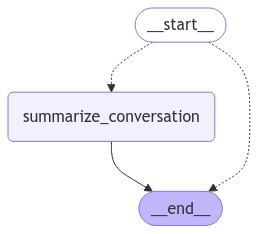

In [25]:
from IPython.display import Image, display

graph = __build_summarize_subgraph().compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

## Tool Call Subgraph

In [28]:
tool_list = [Tools.request_medication_change, Tools.request_appointment_change]
def __build_tool_call_subgraph() -> StateGraph:
    builder = StateGraph(State)
    builder.add_node("ai_agent", __ai_agent)
    builder.add_node("tools", ToolNode(tool_list))

    builder.add_edge(START, "ai_agent")
    builder.add_conditional_edges("ai_agent", tools_condition)
    builder.add_edge("tools", "ai_agent")

    return builder

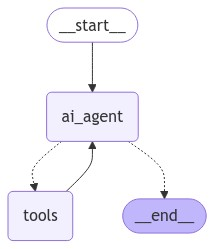

In [29]:
from IPython.display import Image, display

graph = __build_tool_call_subgraph().compile()

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))

In [30]:

def build_graph() -> StateGraph:
    builder = StateGraph(State)
    builder.add_node("summarization_subgraph", __build_summarize_subgraph().compile())
    builder.add_node("tool_call_subgraph", __build_tool_call_subgraph().compile())

    # Set up the flow of the chatbot: start with tool call subgraph, then summarize subgraph, and end
    builder.add_edge(START, "tool_call_subgraph")
    builder.add_edge("tool_call_subgraph", "summarization_subgraph")
    builder.add_edge("summarization_subgraph", END)
    
    return builder



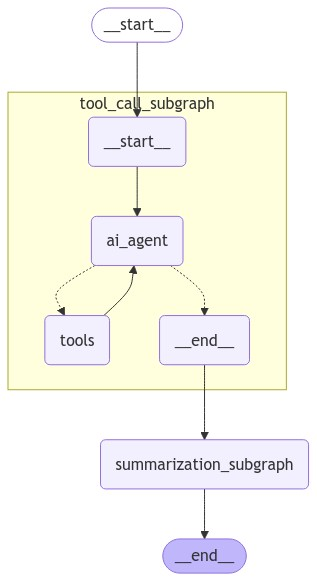

20417

In [34]:
from IPython.display import Image, display

memory = MemorySaver()
graph = build_graph().compile(checkpointer=memory)

display(Image(graph.get_graph(xray=True).draw_mermaid_png()))
open("llm_graph.png", "wb").write(graph.get_graph(xray=True).draw_mermaid_png())


In [ ]:
from pprint import pprint

messages = [HumanMessage(content="My name is Sajed")]
config = {"configurable": {"thread_id": "5"}}
messages = graph.invoke({"messages": messages}, config)
for m in messages['messages']:
    m.pretty_print()
    
pprint(messages)